# 2222 ( Basic Classification )

## What's new:

1- Using scipy for labeling 1


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import talib
from scipy.signal import savgol_filter, find_peaks, peak_prominences


In [3]:
# 1- Load and Scaling Features
# Load and preprocess
df = pd.read_csv('datasets-28-111/XAGUSD-H1-rates.csv', sep='\t')

# Rename columns for easier access
df.rename(columns={
    '<DATE>': 'DATE',
    '<TIME>': 'TIME',
    '<OPEN>': 'OPEN',
    '<HIGH>': 'HIGH',
    '<LOW>': 'LOW',
    '<CLOSE>': 'CLOSE',
    '<TICKVOL>': 'TICKVOL',
    '<VOL>': 'VOL',
    '<SPREAD>': 'SPREAD'
}, inplace=True)

# Optional: Combine DATE and TIME into a single datetime column
df['DATETIME'] = pd.to_datetime(df['DATE'] + ' ' + df['TIME'])

# Drop rows with missing values
df.dropna(inplace=True)

# Sort data chronologically by DATETIME
df.sort_values(by='DATETIME', inplace=True)

# Reset index to ensure clean row order
df.reset_index(drop=True, inplace=True)

# Select features to scale
features = ['OPEN', 'HIGH', 'LOW', 'CLOSE', 'TICKVOL']

# Apply MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features])

In [5]:
def label_reversal_points(
    close,
    base_prom_factor=0.02,   # was 0.05 → reduced to detect smaller swings
    smoothing_window=31,     # was auto ~60 → reduced for more sensitivity
    distance=3,              # was 5 → allow closer peaks
    max_iterations=4,
    verbose=True
):
    import numpy as np
    from scipy.signal import savgol_filter, find_peaks, peak_prominences

    close = np.asarray(close, dtype=float)
    n = close.size
    labels = np.zeros(n, dtype=int)

    # smooth to remove only very high-frequency noise
    if smoothing_window >= n:
        smoothing_window = n - 1 if (n - 1) % 2 == 1 else n - 2
    if smoothing_window % 2 == 0:
        smoothing_window += 1
    smoothed = savgol_filter(close, smoothing_window, 3)

    std = np.std(close)
    if std == 0: std = 1.0

    # try progressively smaller prominences if not enough labels
    for i in range(max_iterations):
        prom = std * (base_prom_factor / (2**i))

        peaks, _ = find_peaks(smoothed, distance=distance, prominence=prom)
        valleys, _ = find_peaks(-smoothed, distance=distance, prominence=prom)

        all_extremes = sorted([(p, 2) for p in peaks] + [(v, 1) for v in valleys])

        # enforce alternation: remove duplicates of same type
        filtered = []
        for idx, typ in all_extremes:
            if filtered and filtered[-1][1] == typ:
                continue
            filtered.append((idx, typ))

        if verbose:
            print(f"iter {i}: prom={prom:.5f}, extremes={len(filtered)}")

        if len(filtered) > n * 0.005:  # ~300 for 60k
            break

    for idx, typ in filtered:
        labels[idx] = typ

    # mark first and last
    if labels[0] == 0:
        labels[0] = 1 if close[1] > close[0] else 2
    if labels[-1] == 0:
        labels[-1] = 1 if close[-1] > close[-2] else 2

    return labels


In [6]:
# default call (good starting point for ~60k hourly FX rows)
df['Label'] = label_reversal_points(df['CLOSE'].values)

# inspect counts
print(df['Label'].value_counts())

iter 0: prom=0.08015, extremes=1343
Label
0    53738
2      673
1      672
Name: count, dtype: int64


In [8]:
def plot_labeled_candles(df, n=150):
    """
    Plots the last n candles with BUY/SELL labels based on the 'Label' column.
    """
    # Use only the last n rows
    df_plot = df.tail(n).copy()
    df_plot['DATETIME'] = df_plot['DATE'] + ' ' + df_plot['TIME']

    # Plot the closing price
    plt.figure(figsize=(15, 6))
    plt.plot(df_plot['DATETIME'], df_plot['CLOSE'], label='Close Price', color='black', linewidth=1.5)

    # Plot BUY (label=1) and SELL (label=2) signals
    for idx, row in df_plot.iterrows():
        if row['Label'] == 1:
            plt.axvline(x=row['DATETIME'], color='green', linestyle='--', linewidth=1)
            plt.text(row['DATETIME'], row['CLOSE'], 'BUY', color='green', ha='center', va='bottom', fontsize=9)
        elif row['Label'] == 2:
            plt.axvline(x=row['DATETIME'], color='red', linestyle='--', linewidth=1)
            plt.text(row['DATETIME'], row['CLOSE'], 'SELL', color='red', ha='center', va='top', fontsize=9)

    plt.title(f'Last {n} Candles with Trend Reversal Labels')
    plt.xlabel('Datetime')
    plt.ylabel('Close Price')
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.legend()
    plt.show()

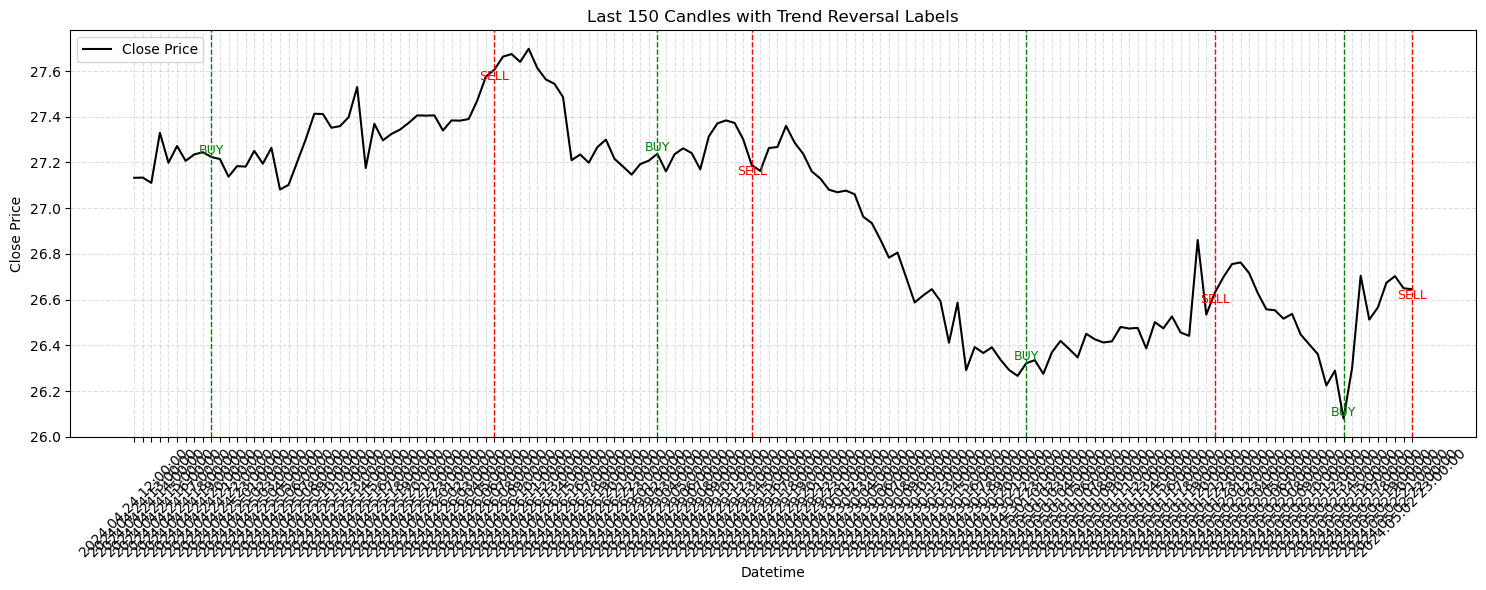

In [9]:
plot_labeled_candles(df)

# plot section